# 基本假设：
1. 总共100000客户参与当日交易（总时长4小时），每客户下单时间遵循uniform分布。
2. 每次竞价周期，每位客户是买家或卖家遵循Bernoulli分布，B(0.5)。
3. 每位买家或卖家委托数量统一为1单。买家价量和卖家价量遵循normal分布。买家价量分布平均值低于前一次成交价格2%，卖家价量分布平均值高于前一次成交价格2%。
4. 撤单时间遵循Beta分布，不考虑成交价格对其的影响。
5. 下单间隔时间符合泊松分布，且需要满足在一轮竞价周期结束后或其撤单后，在该天所有交易结束前。

In [1]:
# 导入packages 
import numpy as np
import matplotlib.pyplot as plt

## 建立客户初始下单模型

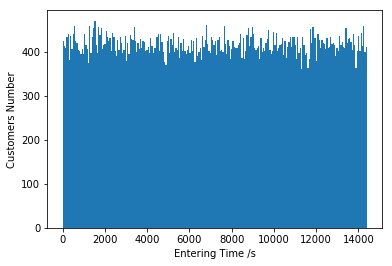

In [2]:
# 建立客户下单时间模型, 精确到秒
customers = 100000
overall_time = 4*60*60
customers_entering_time = np.random.uniform(0,overall_time,customers).astype('int')
plt.hist(customers_entering_time, normed=False, bins=overall_time//60)
plt.ylabel('Customers Number')
plt.xlabel('Entering Time /s')

在本次探索阶段，不妨假设每轮竞价周期为10分钟。

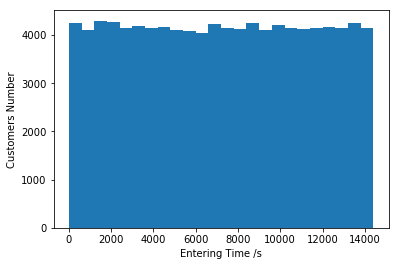

In [3]:
T=10*60
plt.hist(customers_entering_time, normed=False, bins=overall_time//T)
plt.ylabel('Customers Number')
plt.xlabel('Entering Time /s')

## 定义每轮竞价周期买卖家数量

In [4]:
# [进入时间; 买（1）或卖（0）; 价钱; 是否成交？; 撤回时间]
buyer_seller_rate = 0.5
array = np.zeros((customers, 5))
array[:,0] = customers_entering_time
buyer_or_seller = np.random.binomial(1, buyer_seller_rate, size=customers)
array[:,1] = buyer_or_seller

In [5]:
#array = array.astype('int')

## 从首轮竞价开始迭代推演

In [6]:
# 定义买卖价格正态分布参数
buy_bias = 0.02
buy_sigma = 8
sell_sigma = 8
sell_bias = 0.02
# 定义撤回时间beta分布参数
alpha = 2.5
beta = 1
coeff1 = 4*60*60 #4小时
# 定义下单时间间隔poisson分布参数
nombda = 10
coeff2 = 6*60 #6分钟

# 定义集合竞价函数
def get_price_and_volumn(commission):
    #print(len(commission))
    buy_array = commission[commission[:, 1]==1]
    buy_array = buy_array[buy_array[:, 3]!=1]
    sell_array = commission[commission[:, 1]==0]
    sell_array = sell_array[sell_array[:, 3]!=1]
    #买从高到低
    buy_array = np.array(sorted(buy_array, key=lambda a_entry: a_entry[2], reverse=True))
    #卖从低到高
    sell_array = np.array(sorted(sell_array, key=lambda a_entry: a_entry[2]))
    price = 0
    volumn = 0
    i = 0
    min_len = min(len(buy_array[:, 2]), len(sell_array[:, 2]))
    while i<min_len and buy_array[i, 2] >= sell_array[i, 2]:
        volumn += 1
        buy_array[i, 3]=1
        sell_array[i, 3]=1
        i += 1
    if i != 0:
        price = (buy_array[i-1, 2]+sell_array[i-1, 2])/2
        #print(buy_array[i-1, 2], sell_array[i-1, 2])
    
    #返回没有成交的委托
    unsettled = np.append(buy_array[buy_array[:, 3]==0], sell_array[sell_array[:, 3]==0], axis=0)
    
    return price, volumn, unsettled
        

# 定义每轮竞价周期成交价格函数，方便多次使用
def final_price_and_volumn(start_price, commission, period, array):
    buy_mu = start_price * (1-buy_bias)
    sell_mu = start_price * (1+sell_bias)
    commission = list(commission)
    for bid in commission:
        #定义买或卖价钱
        #根据生成时间来判断这个bid是之前遗留下来的还是新进入的
        if bid[0] >= period[0]: 
            if bid[1] == 1: 
                #bid[2] = int(np.random.normal(buy_mu, buy_sigma, 1))
                bid[2] = np.random.normal(buy_mu, buy_sigma, 1)
            else:
                #bid[2] = int(np.random.normal(sell_mu, sell_sigma, 1))
                bid[2] = np.random.normal(sell_mu, sell_sigma, 1)
    
        #定义撤回时间
        if bid[0] >= period[0]: 
            bid[4] = int(np.random.beta(alpha, beta, 1) * coeff1 + bid[0])
        if bid[4] >= period[0] and bid[4]<period[1]: 
            bid[3] = 1
        
        #定义新的下单时间
        if bid[0]>=period[0]:
            temp = int(np.random.poisson(nombda) * coeff2 + bid[0])
            new_time = temp
            new_buy_or_sell = int(np.random.binomial(1, buyer_seller_rate, 1))
            #new = np.array([new_time, new_buy_or_sell, 0, 0, 0])
            if new_time >= period[1] and new_time<overall_time:
                #print("hello")
                array = np.append(array, np.array([[new_time, new_buy_or_sell, 0, 0, 0]]), axis=0)
            elif new_time<period[1] and new_time>=bid[4] and new_time>=period[0]:
                commission.append(np.array([new_time, new_buy_or_sell, 0, 0, 0]))
    commission = np.array(commission)
    #print(commission)
    #进行排序后确定成交价格
    price, volumn, unsettled = get_price_and_volumn(commission)
    return price, volumn, unsettled, array 
    

In [7]:
# 假设昨日成交价格为100。
start_price = 100
price_list = []
volumn_list = []
for i in range(overall_time//T):
    period = [i*T, (i+1)*T]
    commission = array[period[0]<=array[:, 0]]
    commission = commission[commission[:, 0]<period[1]]
    if i != 0:
        commission = np.append(commission, unsettled, axis=0)
    price, volumn, unsettled, array = final_price_and_volumn(start_price, commission, period, array)
    if price == 0:
        if len(price_list)==0:
            start_price = 100
        else:
            start_price=price_list[-1]
    else:
        start_price = price
    price_list.append(start_price)
    volumn_list.append(volumn)

In [8]:
price_list

[100.02548305569317,
 99.890662316118664,
 100.10074766818076,
 100.09204723816632,
 100.12185507346402,
 100.11961310582255,
 100.09390317658774,
 100.1460800410949,
 100.07587697828927,
 100.09058985661153,
 100.05954650990765,
 100.14430770506698,
 100.16497658362788,
 100.17448142104232,
 100.20399078153324,
 100.17090325595963,
 100.11988380488401,
 100.19740396649182,
 100.18063607440854,
 100.17597384693647,
 100.1474398734554,
 100.17183468307891,
 100.12289390469618,
 100.17347837502732]

In [9]:
volumn_list

[836,
 835,
 912,
 918,
 1017,
 1195,
 1391,
 1566,
 1647,
 1788,
 1894,
 2066,
 2230,
 2341,
 2509,
 2565,
 2755,
 2928,
 2980,
 3214,
 3305,
 3456,
 3739,
 3709]

In [10]:
# 优化目标
a1 = 2
a2 = -50000
Y = a1*sum(volumn_list)+a2*np.std(price_list)
Y

100291.88887512231

## 绘制随T变化曲线

In [11]:
customers = 100000
overall_time = 4*60*60
buyer_seller_rate = 0.5
# 定义买卖价格正态分布参数
buy_bias = 0.02
buy_sigma = 8
sell_sigma = 8
sell_bias = 0.02
# 定义下单时间间隔poisson分布参数
nombda = 10
coeff2 = 6*60 #6分钟
# 假设昨日成交价格为100。
start_price = 100

# 定义集合竞价函数
def get_price_and_volumn(commission):
    #print(len(commission))
    buy_array = commission[commission[:, 1]==1]
    buy_array = buy_array[buy_array[:, 3]!=1]
    sell_array = commission[commission[:, 1]==0]
    sell_array = sell_array[sell_array[:, 3]!=1]
    #买从高到低
    buy_array = np.array(sorted(buy_array, key=lambda a_entry: a_entry[2], reverse=True))
    #卖从低到高
    sell_array = np.array(sorted(sell_array, key=lambda a_entry: a_entry[2]))
    price = 0
    volumn = 0
    i = 0
    min_len = min(len(buy_array[:, 2]), len(sell_array[:, 2]))
    while i<min_len and buy_array[i, 2] >= sell_array[i, 2]:
        volumn += 1
        buy_array[i, 3]=1
        sell_array[i, 3]=1
        i += 1
    if i != 0:
        price = (buy_array[i-1, 2]+sell_array[i-1, 2])/2
        #print(buy_array[i-1, 2], sell_array[i-1, 2])
    
    #返回没有成交的委托
    unsettled = np.append(buy_array[buy_array[:, 3]==0], sell_array[sell_array[:, 3]==0], axis=0)
    
    return price, volumn, unsettled
        

# 定义每轮竞价周期成交价格函数，方便多次使用
def final_price_and_volumn(start_price, commission, period, array):
    buy_mu = start_price * (1-buy_bias)
    sell_mu = start_price * (1+sell_bias)
    commission = list(commission)
    for bid in commission:
        #定义买或卖价钱
        #根据生成时间来判断这个bid是之前遗留下来的还是新进入的
        if bid[0] >= period[0]: 
            if bid[1] == 1: 
                #bid[2] = int(np.random.normal(buy_mu, buy_sigma, 1))
                bid[2] = np.random.normal(buy_mu, buy_sigma, 1)
            else:
                #bid[2] = int(np.random.normal(sell_mu, sell_sigma, 1))
                bid[2] = np.random.normal(sell_mu, sell_sigma, 1)
    
        #定义撤回时间
        if bid[0] >= period[0]: 
            bid[4] = int(np.random.beta(alpha, beta, 1) * coeff1 + bid[0])
        if bid[4] >= period[0] and bid[4]<period[1]: 
            bid[3] = 1
        
        #定义新的下单时间
        if bid[0]>=period[0]:
            temp = int(np.random.poisson(nombda) * coeff2 + bid[0])
            new_time = temp
            new_buy_or_sell = int(np.random.binomial(1, buyer_seller_rate, 1))
            #new = np.array([new_time, new_buy_or_sell, 0, 0, 0])
            if new_time >= period[1] and new_time<overall_time:
                #print("hello")
                array = np.append(array, np.array([[new_time, new_buy_or_sell, 0, 0, 0]]), axis=0)
            elif new_time<period[1] and new_time>=bid[4] and new_time>=period[0]:
                commission.append(np.array([new_time, new_buy_or_sell, 0, 0, 0]))
    commission = np.array(commission)
    #print(commission)
    #进行排序后确定成交价格
    price, volumn, unsettled = get_price_and_volumn(commission)
    return price, volumn, unsettled, array 
Y_temp = []
x_list = [3, 4, 5, 10, 12, 15, 16, 20, 24, 30, 40, 48, 60]
for T in x_list:
    # 定义撤回时间beta分布参数
    alpha = 2.5
    #beta = 2.5
    coeff1 = 4*60*60 #定义最大撤单时间
    #alpha固定不动，不同的T调节beta
    beta = (9*T+30)/57
    
    T *= 60
    customers_entering_time = np.random.uniform(0,overall_time,customers).astype('int')
    array = np.zeros((customers, 5))
    array[:,0] = customers_entering_time
    buyer_or_seller = np.random.binomial(1, buyer_seller_rate, size=customers)
    array[:,1] = buyer_or_seller
    #array = array.astype('int')
    
    price_list = []
    volumn_list = []
    for i in range(overall_time//T):
        period = [i*T, (i+1)*T]
        commission = array[period[0]<=array[:, 0]]
        commission = commission[commission[:, 0]<period[1]]
        if i != 0:
            commission = np.append(commission, unsettled, axis=0)
        price, volumn, unsettled, array = final_price_and_volumn(start_price, commission, period, array)
        if price == 0:
            if len(price_list)==0:
                start_price = 100
            else:
                start_price=price_list[-1]
        else:
            start_price = price
        price_list.append(start_price)
        volumn_list.append(volumn)
    Y = (sum(volumn_list), np.std(price_list))
    Y_temp.append(Y)

In [28]:
# 优化目标
a1 = 1
a2 = -100000
Y_list = [a1*y[0]+a2*y[1] for y in Y_temp]

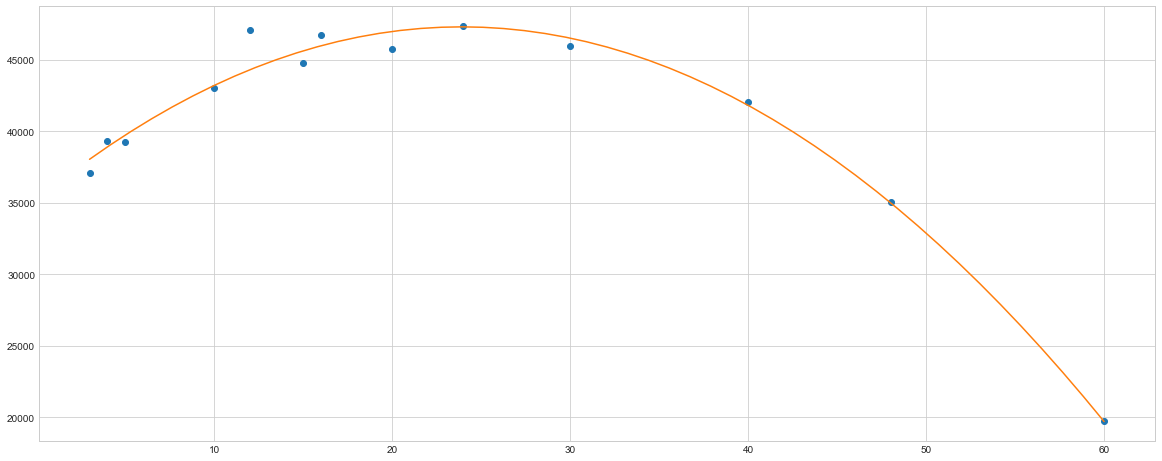

In [29]:
z = np.polyfit(x_list, Y_list, 2)
f = np.poly1d(z)
# calculate new x's and y's
x_new = np.linspace(x_list[0], x_list[-1], 50)
y_new = f(x_new)
plt.plot(x_list,Y_list,'o', x_new, y_new)
#plt.plot(x_list, Y_list)

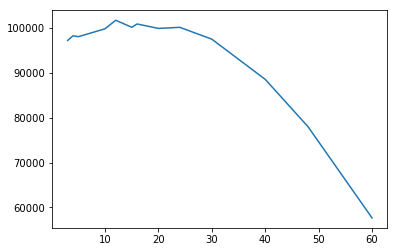

In [14]:
plt.plot(x_list, Y_list)

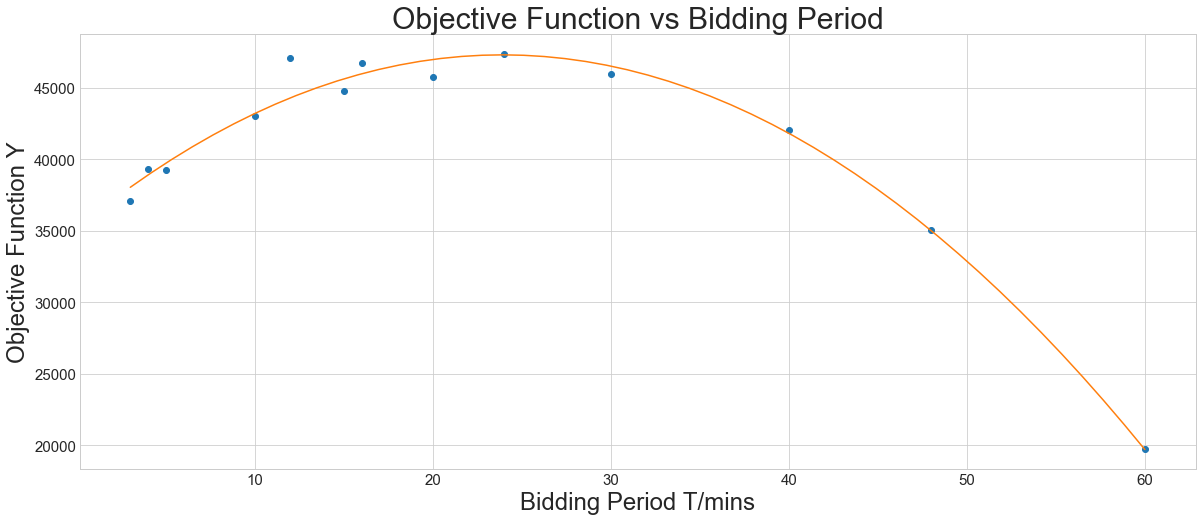

In [30]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [20, 8]
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(x_list,Y_list,'o', x_new, y_new)
plt.ylabel('Objective Function Y', fontsize=24)
plt.xlabel('Bidding Period T/mins', fontsize=24)
plt.title('Objective Function vs Bidding Period', fontsize=30)

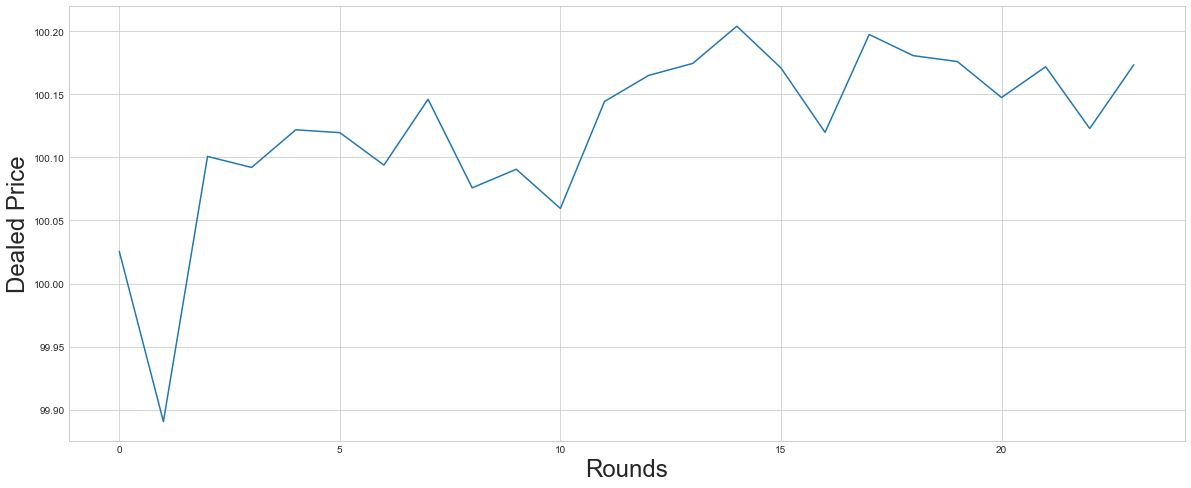

In [32]:
test = [100.02548305569317,
 99.890662316118664,
 100.10074766818076,
 100.09204723816632,
 100.12185507346402,
 100.11961310582255,
 100.09390317658774,
 100.1460800410949,
 100.07587697828927,
 100.09058985661153,
 100.05954650990765,
 100.14430770506698,
 100.16497658362788,
 100.17448142104232,
 100.20399078153324,
 100.17090325595963,
 100.11988380488401,
 100.19740396649182,
 100.18063607440854,
 100.17597384693647,
 100.1474398734554,
 100.17183468307891,
 100.12289390469618,
 100.17347837502732]
plt.plot(test)
plt.xlabel('Rounds', fontsize=24)
plt.ylabel('Dealed Price', fontsize=24)

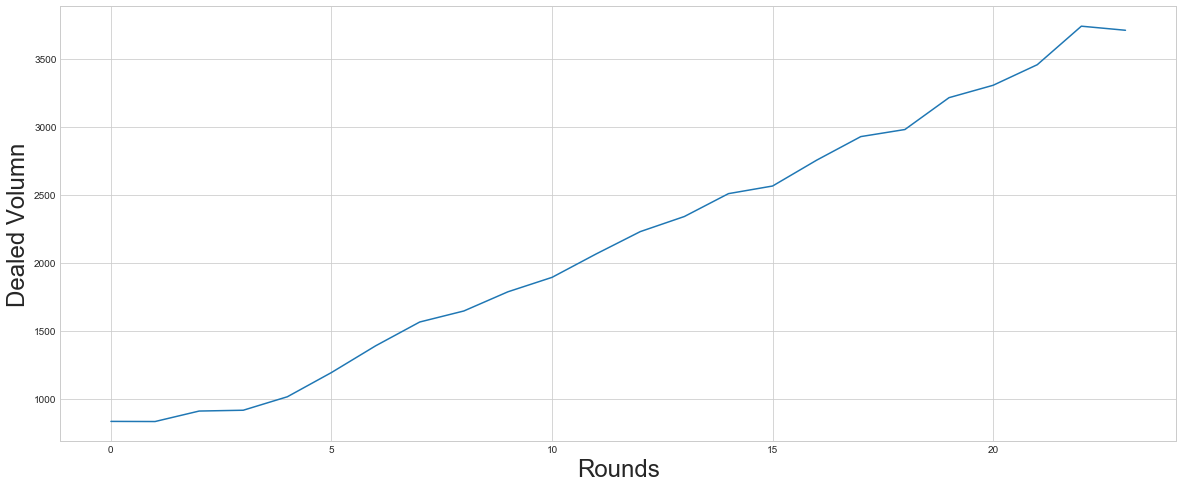

In [33]:
test = [836,
 835,
 912,
 918,
 1017,
 1195,
 1391,
 1566,
 1647,
 1788,
 1894,
 2066,
 2230,
 2341,
 2509,
 2565,
 2755,
 2928,
 2980,
 3214,
 3305,
 3456,
 3739,
 3709]
plt.plot(test)
plt.xlabel('Rounds', fontsize=24)
plt.ylabel('Dealed Volumn', fontsize=24)